<a href="https://colab.research.google.com/github/ryanghhh/Lecture/blob/main/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%A0%95%EA%B8%B0%EC%98%88%EA%B8%88%20%EA%B0%80%EC%9E%85%20%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
import os
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

pip install xgboost

SyntaxError: invalid syntax (ipython-input-924939459.py, line 9)

In [88]:
# train 파일 load
from google.colab import drive
drive.mount('/content/drive')
csv_path = '/content/drive/MyDrive/대학원/머신러닝 수업/머신러닝 과제/train.csv'

train_data = pd.read_csv(csv_path)
print(train_data.shape)
train_data.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(32950, 21)


,id,age,job,marital,education,default,housing,loan,contact,month,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,19495,36,technician,married,university.degree,no,yes,yes,cellular,aug,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.968,5228.1,no
1,38793,28,admin.,single,university.degree,no,yes,no,cellular,nov,...,2,999,0,nonexistent,-3.4,92.649,-30.1,0.714,5017.5,no
2,27160,57,management,divorced,professional.course,no,yes,no,cellular,nov,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,no
3,36476,24,blue-collar,single,basic.9y,no,unknown,unknown,cellular,jun,...,1,999,0,nonexistent,-2.9,92.963,-40.8,1.260,5076.2,no
4,38007,24,student,single,basic.9y,no,unknown,unknown,cellular,sep,...,1,999,0,nonexistent,-3.4,92.379,-29.8,0.788,5017.5,yes


In [89]:
# test 파일 load
from google.colab import drive
drive.mount('/content/drive')
csv_path = '/content/drive/MyDrive/대학원/머신러닝 수업/머신러닝 과제/test.csv'

test_data = pd.read_csv(csv_path)
print(test_data.shape)
test_data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(8238, 20)


,id,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,8626,27,technician,single,university.degree,no,no,yes,telephone,jun,wed,1,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1
1,6749,29,services,married,basic.9y,no,yes,no,telephone,may,wed,3,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2,7227,59,admin.,married,high.school,no,yes,no,telephone,may,thu,4,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0
3,12558,52,entrepreneur,married,university.degree,no,yes,no,cellular,jul,mon,3,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1
4,9628,40,technician,married,professional.course,no,no,no,telephone,jun,mon,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1


In [90]:
# 원본 파일 유지를 위해 train data 깊은 복사
df = train_data.copy()

print('type(df):', type(df))

type(df): <class 'pandas.core.frame.DataFrame'>


In [91]:
#결측치 확인. 있으면 true = 1. 없으면 0
print(df.isna().sum())

id                0
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


In [92]:
#각 컬럼별 unknown 갯수 확인
unknown_counts = {}

for col in df.columns:
    cnt = (df[col].astype(str).str.lower() == 'unknown').sum()
    unknown_counts[col] = cnt

import pandas as pd
pd.DataFrame.from_dict(unknown_counts, orient='index', columns=['unknown_count'])

,unknown_count
id,0
age,0
job,262
marital,62
education,1371
default,6859
housing,790
loan,790
contact,0
month,0


In [93]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_features = ['age','campaign','pdays','previous',
                    'emp.var.rate','cons.price.idx','cons.conf.idx',
                    'euribor3m','nr.employed']

categorical_features = ['job','marital','education','default','housing','loan',
                        'contact','month','day_of_week','poutcome']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(with_mean=False), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [94]:
df2 = df.copy()

numeric_cols = df2.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
    print(f"--- {col} ---")
    print(df[col].quantile([0, 0.25, 0.5, 0.75, 1]))
    print()

--- id ---
0.00        1.00
0.25    10272.25
0.50    20587.00
0.75    30854.75
1.00    41187.00
Name: id, dtype: float64

--- age ---
0.00    17.0
0.25    32.0
0.50    38.0
0.75    47.0
1.00    98.0
Name: age, dtype: float64

--- campaign ---
0.00     1.0
0.25     1.0
0.50     2.0
0.75     3.0
1.00    56.0
Name: campaign, dtype: float64

--- pdays ---
0.00      0.0
0.25    999.0
0.50    999.0
0.75    999.0
1.00    999.0
Name: pdays, dtype: float64

--- previous ---
0.00    0.0
0.25    0.0
0.50    0.0
0.75    0.0
1.00    7.0
Name: previous, dtype: float64

--- emp.var.rate ---
0.00   -3.4
0.25   -1.8
0.50    1.1
0.75    1.4
1.00    1.4
Name: emp.var.rate, dtype: float64

--- cons.price.idx ---
0.00    92.201
0.25    93.075
0.50    93.749
0.75    93.994
1.00    94.767
Name: cons.price.idx, dtype: float64

--- cons.conf.idx ---
0.00   -50.8
0.25   -42.7
0.50   -41.8
0.75   -36.4
1.00   -26.9
Name: cons.conf.idx, dtype: float64

--- euribor3m ---
0.00    0.634
0.25    1.344
0.50    4.857
0

In [95]:
#campaign 변수만 cap(상한선) 적용

q3 = df2['campaign'].quantile(0.75)   # 3
iqr = q3 - df2['campaign'].quantile(0.25)  # 2
upper = q3 + 1.5 * iqr  # 6

df2['campaign'] = df2['campaign'].clip(upper=upper)


In [96]:
df2['campaign'].max()
# 상한선 적용되었는지 확인

6

In [97]:
numeric_cols = df2.select_dtypes(include=['int64','float64']).columns

for col in numeric_cols:
    Q1 = df2[col].quantile(0.25)
    Q3 = df2[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR

    outliers = df2[(df2[col] < lower) | (df2[col] > upper)][col].count()

    print(f"{col}: 이상치 개수 = {outliers},  허용범위=({lower:.2f}, {upper:.2f})")


  #previous zero-inflation 때문에 대부분이 0이라 이상치로 잡힐 뿐임. 그러나 7회 연락도 충분히 정상적인 이벤트 → 제거/수정하면 절대 안 됨
  #cons.conf.idx: 소비자 신뢰지수 - 경제지표(economic indicators)는 본래 분포가 좁고 변동이 적음. -50.8 ~ -26.9는 실제 공식 통계 지표 범위 범위 벗어난 값이 아니라 IQR이 너무 빡세게 잡혀서 outlier처럼 보일 뿐 ❌ 수정/제거 필요 없음
  #campaign = 연락 횟수 - 실제 데이터 max = 56이므로 👉 6보다 큰 값은 실제로 이상치처럼 보일 수 있음 📌 과제에서는 campaign 상한선 clip을 할 수도 있고 📌 그냥 둬도 모델 성능에 큰 영향 없음 👉 하지만 clip(6) 처리가 가장 깔끔한 선택

id: 이상치 개수 = 0,  허용범위=(-20601.50, 61728.50)
age: 이상치 개수 = 374,  허용범위=(9.50, 69.50)
campaign: 이상치 개수 = 0,  허용범위=(-2.00, 6.00)
pdays: 이상치 개수 = 1215,  허용범위=(999.00, 999.00)
previous: 이상치 개수 = 4494,  허용범위=(0.00, 0.00)
emp.var.rate: 이상치 개수 = 0,  허용범위=(-6.60, 6.20)
cons.price.idx: 이상치 개수 = 0,  허용범위=(91.70, 95.37)
cons.conf.idx: 이상치 개수 = 364,  허용범위=(-52.15, -26.95)
euribor3m: 이상치 개수 = 0,  허용범위=(-4.08, 10.39)
nr.employed: 이상치 개수 = 0,  허용범위=(4905.60, 5421.60)


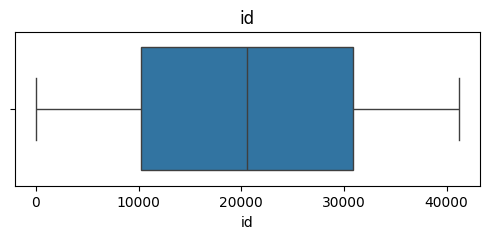

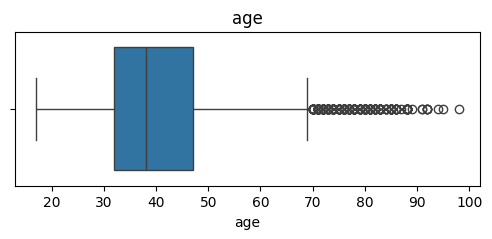

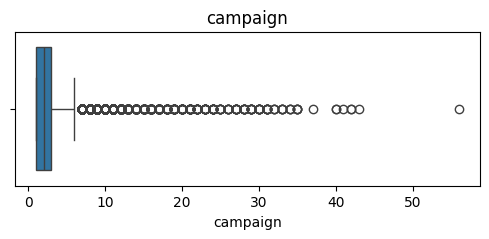

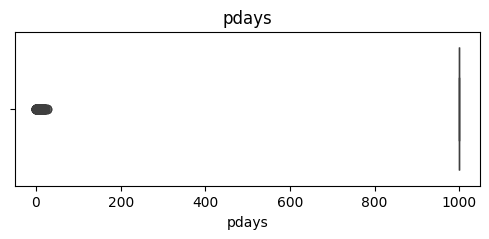

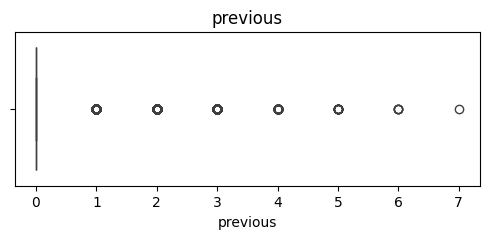

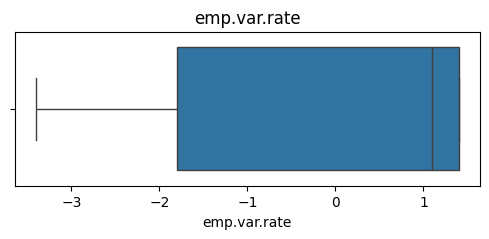

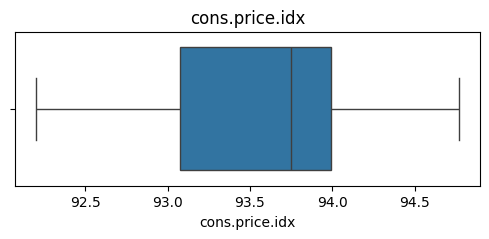

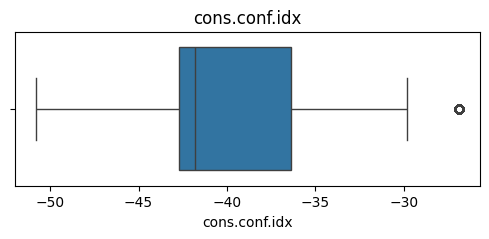

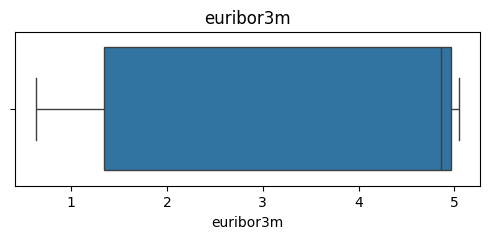

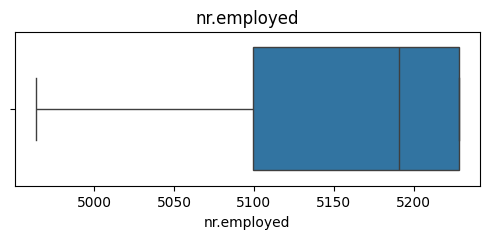

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in numeric_cols:
    plt.figure(figsize=(6,2))
    sns.boxplot(x=df[col])
    plt.title(col)
    plt.show()


In [99]:
# 타깃 y를 0/1로 바꾸기
# 0 : 미가입 / 1 : 가입
import numpy as np

df3 = df2.copy()

# y: "yes"→1, "no"→0
df3['y'] = (df3['y'].astype(str).str.lower() == 'yes').astype(int)

X = df3.drop(columns=['y'])
y = df3['y']

In [100]:
#모델링

models = {
    'Logistic': LogisticRegression(
        max_iter=2000,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    ),
    'RandomForest': RandomForestClassifier(
        n_estimators=300,
        min_samples_leaf=2,
        class_weight='balanced_subsample',
        n_jobs=-1,
        random_state=42
    ),
    'XGBoost': XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    )
}

pipelines = {
    name: Pipeline(steps=[
        ('preprocess', preprocessor),
        ('model', clf)
    ])
    for name, clf in models.items()
}


In [101]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}

for name, pipe in pipelines.items():
    # 각 fold에서 확률 예측
    y_prob_cv = cross_val_predict(
        pipe, X, y,
        cv=cv,
        method='predict_proba',
        n_jobs=-1
    )[:, 1]

    y_pred_cv = (y_prob_cv >= 0.5).astype(int)

    acc = accuracy_score(y, y_pred_cv)
    f1  = f1_score(y, y_pred_cv)
    auc = roc_auc_score(y, y_prob_cv)

    score = (acc + f1 + auc) / 3

    results[name] = {
        'ACC': acc,
        'F1': f1,
        'AUC': auc,
        'MeanScore': score
    }

results_df = pd.DataFrame(results).T
print(results_df.sort_values('MeanScore', ascending=False))


                   ACC        F1       AUC  MeanScore
RandomForest  0.883065  0.486882  0.791306   0.720418
XGBoost       0.900182  0.388093  0.797241   0.695172
Logistic      0.827436  0.452216  0.789150   0.689600


In [102]:
best_model_name = results_df['MeanScore'].idxmax()
best_model_name

'RandomForest'

In [103]:
best_pipe = pipelines['RandomForest']
test_df = test_data.copy()

# 학습
best_pipe.fit(X, y)

# 예측
y_prob_test = best_pipe.predict_proba(test_df)[:, 1]
y_pred_test = (y_prob_test >= 0.5).astype(int)

# 파일 생성
prediction = pd.DataFrame({
    'id': test_df['id'],
    'y_predict': y_pred_test,
    'y_prob': y_prob_test
})

prediction.to_csv('prediction.csv', index=False)
prediction.head()

# 0미가입 1 가입

,id,y_predict,y_prob
0,8626,0,0.234553
1,6749,0,0.028042
2,7227,0,0.119153
3,12558,0,0.150397
4,9628,0,0.059650


In [104]:
counts = prediction['y_predict'].value_counts()
print("미가입(0) 인원:", counts.get(0, 0))
print("가입(1) 인원:", counts.get(1, 0))
print("총 인원:", len(prediction))


미가입(0) 인원: 7258
가입(1) 인원: 980
총 인원: 8238


In [105]:
ratio = prediction['y_predict'].value_counts(normalize=True)
print("미가입(0) 비율:", ratio.get(0, 0))
print("가입(1) 비율:", ratio.get(1, 0))

미가입(0) 비율: 0.8810390871570769
가입(1) 비율: 0.11896091284292304
